# BMI and Age relationship to cell proportions in Schildkraut HGSOC

We hypothesised that clinical factors such as stage, age, BMI, etc., might shape the intra-tumour cell mix. To test this, we first correlated each macro-fraction (adipocytes, stromal, immune and epithelial) with age and with BMI (the two continuous variables) using Spearman’s ρ (eight tests in total) and then fit a β-regression that estimates the change in fraction produced by a one-standard-deviation rise in each predictor.
For the Spearman correlation screen, none of the eight correlations remained significant after Bonferroni adjustment (all p-adj ≥ 0.70) (Fig. 3a-b). The strongest raw signal was a weak negative correlation between age and the immune fraction (ρ = −0.071, p = 0.088, p-adj = 0.70). 

Beta-regression, which simultaneously adjusts for age and BMI and models residual heteroskedasticity via the precision sub-model, likewise detected no association that survived multiplicity control (Fig. 3c-d). The strongest trend was a decrease in immune-cell proportion with increasing age (β = –0.046 per SD, 95 % CI –0.090 to –0.002, p = 0.039), but this was not significant after Bonferroni adjustment (p-adj = 0.31). Estimated effects for stromal, adipocyte and epithelial fractions were small and imprecise (|β| ≤ 0.065; all p-adj ≥ 0.68). Diagnostic plots showed symmetric, homoscedastic residuals with only a handful of moderate-influence points (Cook’s D ≤ 0.33); exclusion of those points did not materially change any coefficient.

 Collectively, these analyses indicate that BMI and age explain little of the inter-patient variability in tumour adipocyte, stromal, immune or epithelial content within this cohort.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from scipy.stats import spearmanr
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests
from statsmodels.othermod.betareg import BetaModel
import sys

sys.path.insert(1, "../../")
sys.path.insert(1, "../")

import src.hp as hp

np.random.seed(88)

In [2]:
fractions = ["Adipocytes", "Immune", "Stromal", "Epithelial"]

remove_999_BMI = True

cont_cols = ["Age", "BMI"]

## Load survival metadata

In [3]:
base_path = os.path.dirname(os.getcwd())
meta_path = os.path.join(base_path, "input_data/metadata.xlsx")

## Load InstaPrism cell-fraction tables (processed) and metadata

Proportions

In [4]:
props = pd.read_csv(
    os.path.join(base_path, "input_data/proportions_sch.csv"), index_col=0
)
props

SampleID   Plasma cells   B cells  Endothelial cells       T cells  \
0    18341X10   4.919765e-49  0.052767           0.029870  1.833554e-26   
1    18341X12   9.351753e-92  0.027159           0.011666  5.972580e-66   
2    18341X13   6.998799e-32  0.014663           0.041547  1.004614e-23   
3    18341X14   2.410384e-97  0.162711           0.022343  2.056824e-52   
4    18341X15   3.439318e-76  0.050581           0.055021  5.687981e-28   
..        ...            ...       ...                ...           ...   
583  20160X95  1.442627e-108  0.136578           0.014420  3.410104e-30   
584  20160X96   1.359916e-92  0.190881           0.017396  5.383974e-33   
585  20160X97   7.862780e-79  0.102850           0.053137  8.610293e-03   
586  20160X98   1.245316e-60  0.127050           0.034344  1.345753e-16   
587  20160X99   1.059339e-87  0.058905           0.033258  6.587819e-21   

         Monocytes    Fibroblasts      NK cells  Epithelial cells  \
0     1.727071e-60  7.074672e-105  8.375315e-10          0.746341   
1    2.258210e-157  8.180384e-107  8.135649e-61          0.848153   
2     3.232466e-34   1.225464e-02  9.550579e-19          0.819028   
3     5.485488e-33  2.751866e-120  7.904174e-39          0.642545   
4     5.314872e-52   8.961526e-02  2.919113e-22          0.649017   
..             ...            ...           ...               ...   
583   3.267116e-82   7.666630e-23  1.501224e-35          0.710289   
584   2.734703e-86   1.156925e-02  1.945285e-24          0.592805   
585   1.076987e-46   4.237821e-02  1.467756e-05          0.656171   
586   5.846372e-04   2.787547e-02  2.169830e-04          0.673204   
587   1.283219e-78   5.994087e-02  1.737726e-03          0.697700   

                DC            pDC            ILC    Macrophages  \
0    1.257780e-139   3.590420e-30   2.867046e-78   1.185148e-02   
1    3.276474e-210  2.054386e-103   1.247009e-85  2.337775e-128   
2    1.104356e-115   3.157063e-69   7.123720e-41   2.994756e-02   
3    4.774011e-154   1.326676e-75   2.334007e-77   1.516542e-02   
4    7.625379e-122   1.873123e-52   3.487465e-81   1.419715e-02   
..             ...            ...            ...            ...   
583  6.509988e-151   4.903142e-78  8.571710e-105   3.473745e-03   
584  1.063562e-147   5.374615e-82   8.551669e-96   1.270617e-02   
585  3.397744e-114   5.089409e-39   1.625064e-79   2.253584e-02   
586   4.422809e-95   4.998254e-48   3.881728e-35   5.796692e-04   
587  7.011268e-152   4.270206e-85   1.530139e-54   1.742813e-41   

        Mast cells  Erythroid  Adipocytes       Dataset      suid     ID  
0     1.538137e-57        0.0    0.159171  SchildkrautB  18341X10  45369  
1    1.452291e-115        0.0    0.113022  SchildkrautB  18341X12  47261  
2     1.850941e-63        0.0    0.082561  SchildkrautB  18341X13  47791  
3     1.488048e-80        0.0    0.157235  SchildkrautB  18341X14  47916  
4     4.216693e-41        0.0    0.141568  SchildkrautB  18341X15  48002  
..             ...        ...         ...           ...       ...    ...  
583   5.671299e-79        0.0    0.135240  SchildkrautW  20160X95  47786  
584   4.370517e-04        0.0    0.174205  SchildkrautW  20160X96  47903  
585   9.865474e-05        0.0    0.114204  SchildkrautW  20160X97  47926  
586   4.236351e-47        0.0    0.136146  SchildkrautW  20160X98  47937  
587   5.927558e-84        0.0    0.148458  SchildkrautW  20160X99  47991  

[588 rows x 19 columns]

### Build the analysis table  (clinical + cell fractions)


In [5]:
renaming = hp.get_variable_renaming()
tissue_dictionary = hp.get_tissue_dictionary()

Metadata

In [6]:
meta_full = hp.open_and_clean_meta(
    meta_path=meta_path, renaming=renaming, tissue_dictionary=tissue_dictionary
)

In [7]:
# 999 if unknown BMI, we won't use for BMI and Age analysis.
if remove_999_BMI:
    first = meta_full.shape[0]
    meta_full = meta_full[meta_full["BMI"] != 999]
    print("Removed for BMI 999: ", first - meta_full.shape[0])

Removed for BMI 999:  13


In [8]:
# match index in both
meta_full.index = meta_full.ID
props.index = props.ID
props.drop(columns=["ID", "SampleID", "suid"], inplace=True)

## and merge:
df = meta_full.join(props, how="inner")

cell_types = [
    col for col in df.columns if col not in meta_full.columns and col not in cont_cols
]
cell_types.remove("Dataset")

df

ID  Age  Event   Time_Yrs                    Tissue  Stage  Race  \
ID                                                                             
40143    40143   63      1   8.739220                       NaN      3     1   
41377    41377   54      1   1.180014                       NaN      3     1   
41387    41387   55      1  11.983573                       NaN      3     2   
41391    41391   60      1   4.993840                       NaN      3     1   
41435    41435   59      1   4.057495                       NaN      3     1   
...        ...  ...    ...        ...                       ...    ...   ...   
310266  310266   40      0   9.702186            Fallopian Tube      3     2   
320012  320012   66      0  11.767760                       NaN      3     2   
320025  320025   60      1   6.827869                     Other      3     2   
320043  320043   57      1   1.553425                       NaN      3     2   
320047  320047   52      1   2.696721  Fallopian Tube and Ovary      3     2   

              BMI  AdjTx  Residual  ...      NK cells  Epithelial cells  \
ID                                  ...                                   
40143   23.218229    1.0       4.0  ...  9.808751e-12          0.610632   
41377   17.428942    NaN       3.0  ...  1.760940e-62          0.702189   
41387   45.470350    1.0       2.0  ...  1.680504e-02          0.725604   
41391   31.340800    NaN       3.0  ...  2.241865e-19          0.660983   
41435   23.922658    NaN       NaN  ...  4.262662e-11          0.739953   
...           ...    ...       ...  ...           ...               ...   
310266  28.349557    NaN       NaN  ...  1.374198e-10          0.777904   
320012  37.677475    1.0       4.0  ...  1.048037e-48          0.771372   
320025  38.740537    1.0       3.0  ...  6.829921e-59          0.660166   
320043  19.854802    1.0       4.0  ...  2.474947e-32          0.570443   
320047  34.456489    1.0       3.0  ...  1.676688e-23          0.715866   

                   DC            pDC            ILC    Macrophages  \
ID                                                                   
40143   1.004328e-110   2.784970e-66   3.408820e-86   2.396804e-02   
41377   1.298550e-208  3.770200e-114   5.097006e-86  1.148229e-151   
41387    1.103526e-97   9.654211e-04   3.169795e-58   6.457394e-02   
41391   3.521124e-102   3.787996e-28   1.975079e-50   1.760802e-02   
41435   8.402589e-122   2.637763e-60   2.022724e-88   5.507985e-03   
...               ...            ...            ...            ...   
310266   3.501752e-85   4.856912e-52   2.991107e-53   1.842305e-02   
320012  3.272227e-203  2.444034e-102  2.676690e-115  2.749868e-124   
320025  6.138234e-174   1.089373e-96  7.514971e-104   2.901155e-89   
320043  5.497473e-140   3.027843e-91  1.468406e-104   1.306579e-17   
320047  1.282518e-115   9.471991e-65   2.797211e-87   1.347956e-02   

           Mast cells  Erythroid  Adipocytes       Dataset  
ID                                                          
40143    1.848657e-50        0.0    0.113422  SchildkrautW  
41377   2.716906e-120        0.0    0.169611  SchildkrautW  
41387    9.868737e-88        0.0    0.064832  SchildkrautB  
41391    3.608451e-57        0.0    0.119373  SchildkrautW  
41435    3.092821e-03        0.0    0.110333  SchildkrautW  
...               ...        ...         ...           ...  
310266   3.506149e-04        0.0    0.097551  SchildkrautB  
320012  8.635726e-145        0.0    0.135411  SchildkrautB  
320025   6.676818e-64        0.0    0.181209  SchildkrautB  
320043  3.022363e-131        0.0    0.205731  SchildkrautB  
320047   4.139176e-05        0.0    0.094714  SchildkrautB  

[575 rows x 26 columns]

In [9]:
## Which cell types to use
immune_cells = [
    "B cells",
    "Mast cells",
    "T cells",
    "Monocytes",
    "Plasma cells",
    "NK cells",
    "DC",
    "pDC",
    "Macrophages",
    "ILC",
]

stromal_cells = ["Fibroblasts", "Endothelial cells"]

df["Immune"] = df[immune_cells].sum(axis=1)
df["Epithelial"] = df["Epithelial cells"]
df["Stromal"] = df[stromal_cells].sum(axis=1)

In [10]:
# The assumption of the modelling is no 0 or 1, here we check:
print(df[fractions].agg(["min", "max"]).T)

                     min       max
Adipocytes  3.379658e-02  0.381550
Immune      4.012485e-03  0.399029
Stromal     9.157968e-51  0.679111
Epithelial  6.662326e-02  0.924323


In [11]:
# ── data subset ──────────────────────────────────────────────────────────
macros = df[cont_cols + fractions].dropna().copy()

predictors = cont_cols.copy()

# ── 1.  Spearman correlations + bonferroni --------------------------------------
rows = []
for frac in fractions:
    for pred in predictors:
        rho, p = spearmanr(macros[pred], macros[frac])
        rows.append(
            {"Predictor": pred, "Fraction": frac, "Spearman_ρ": rho, "p_raw": p}
        )

out = pd.DataFrame(rows)

# 4 fractions × 2 predictors = 8 tests
out["p_adj"] = multipletests(out["p_raw"], method="bonferroni")[1]
out = out.sort_values("p_adj")
out.head()
out

Predictor    Fraction  Spearman_ρ     p_raw     p_adj
2       Age      Immune   -0.071224  0.087946  0.703568
0       Age  Adipocytes   -0.014239  0.733313  1.000000
1       BMI  Adipocytes   -0.014106  0.735710  1.000000
3       BMI      Immune    0.028897  0.489216  1.000000
4       Age     Stromal    0.021331  0.609740  1.000000
5       BMI     Stromal   -0.062679  0.133303  1.000000
6       Age  Epithelial    0.024540  0.557039  1.000000
7       BMI  Epithelial    0.026041  0.533161  1.000000

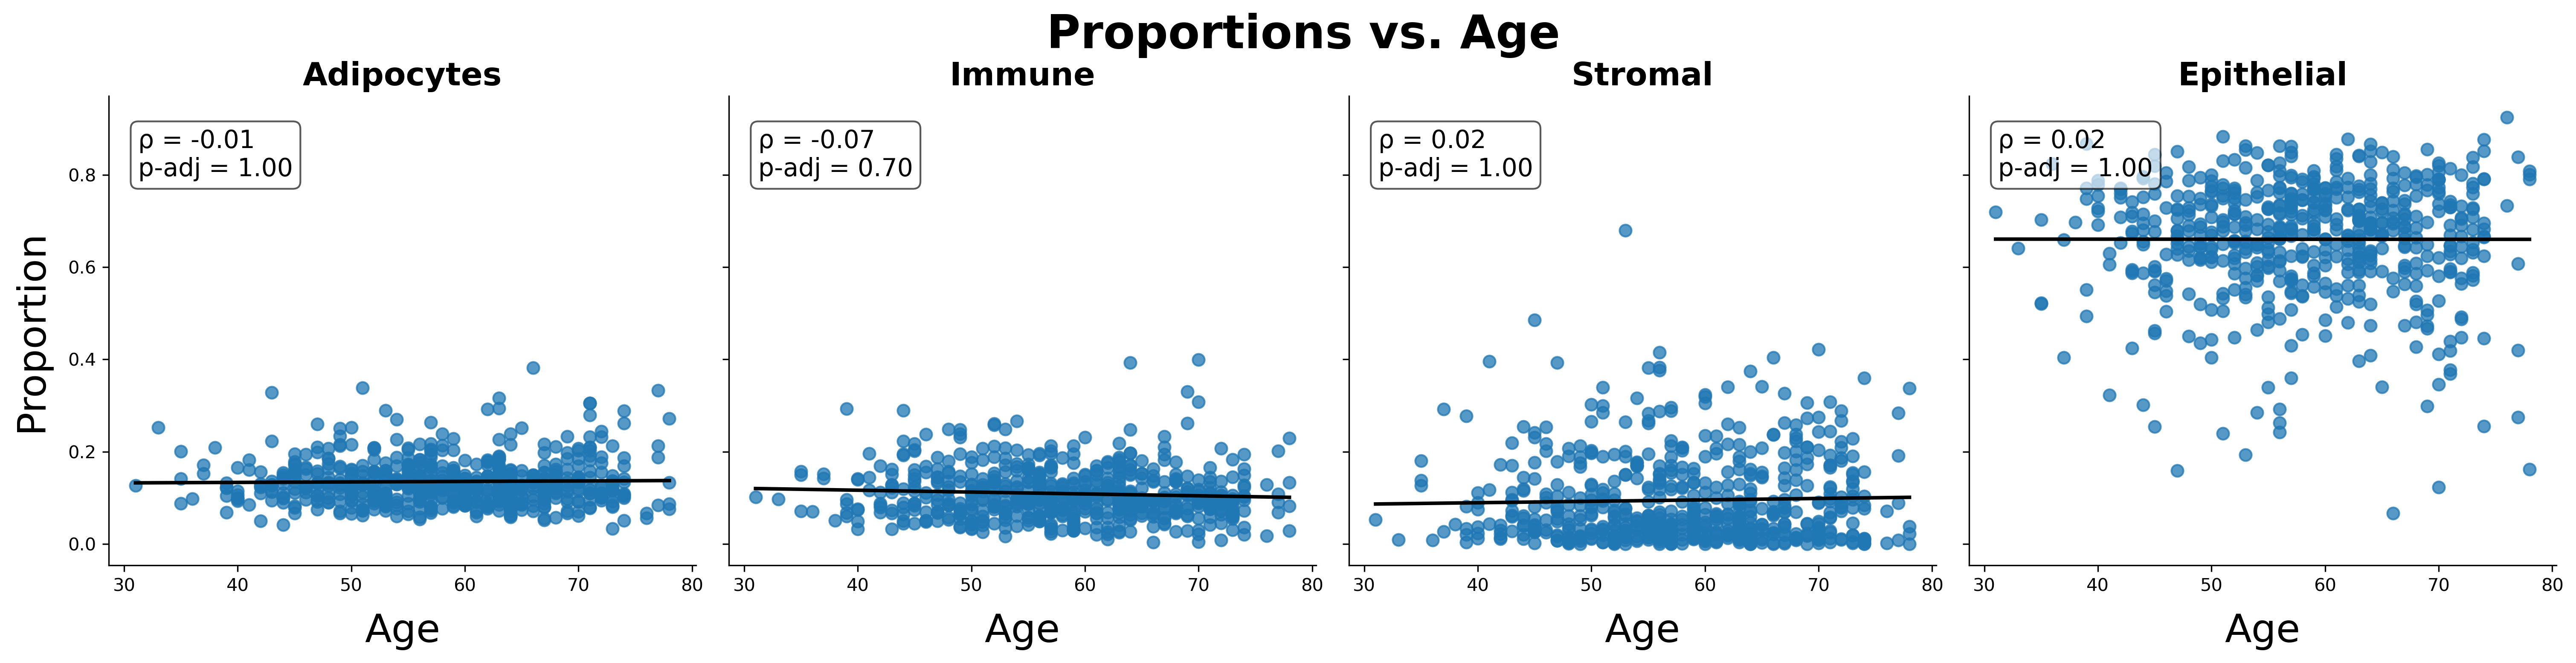

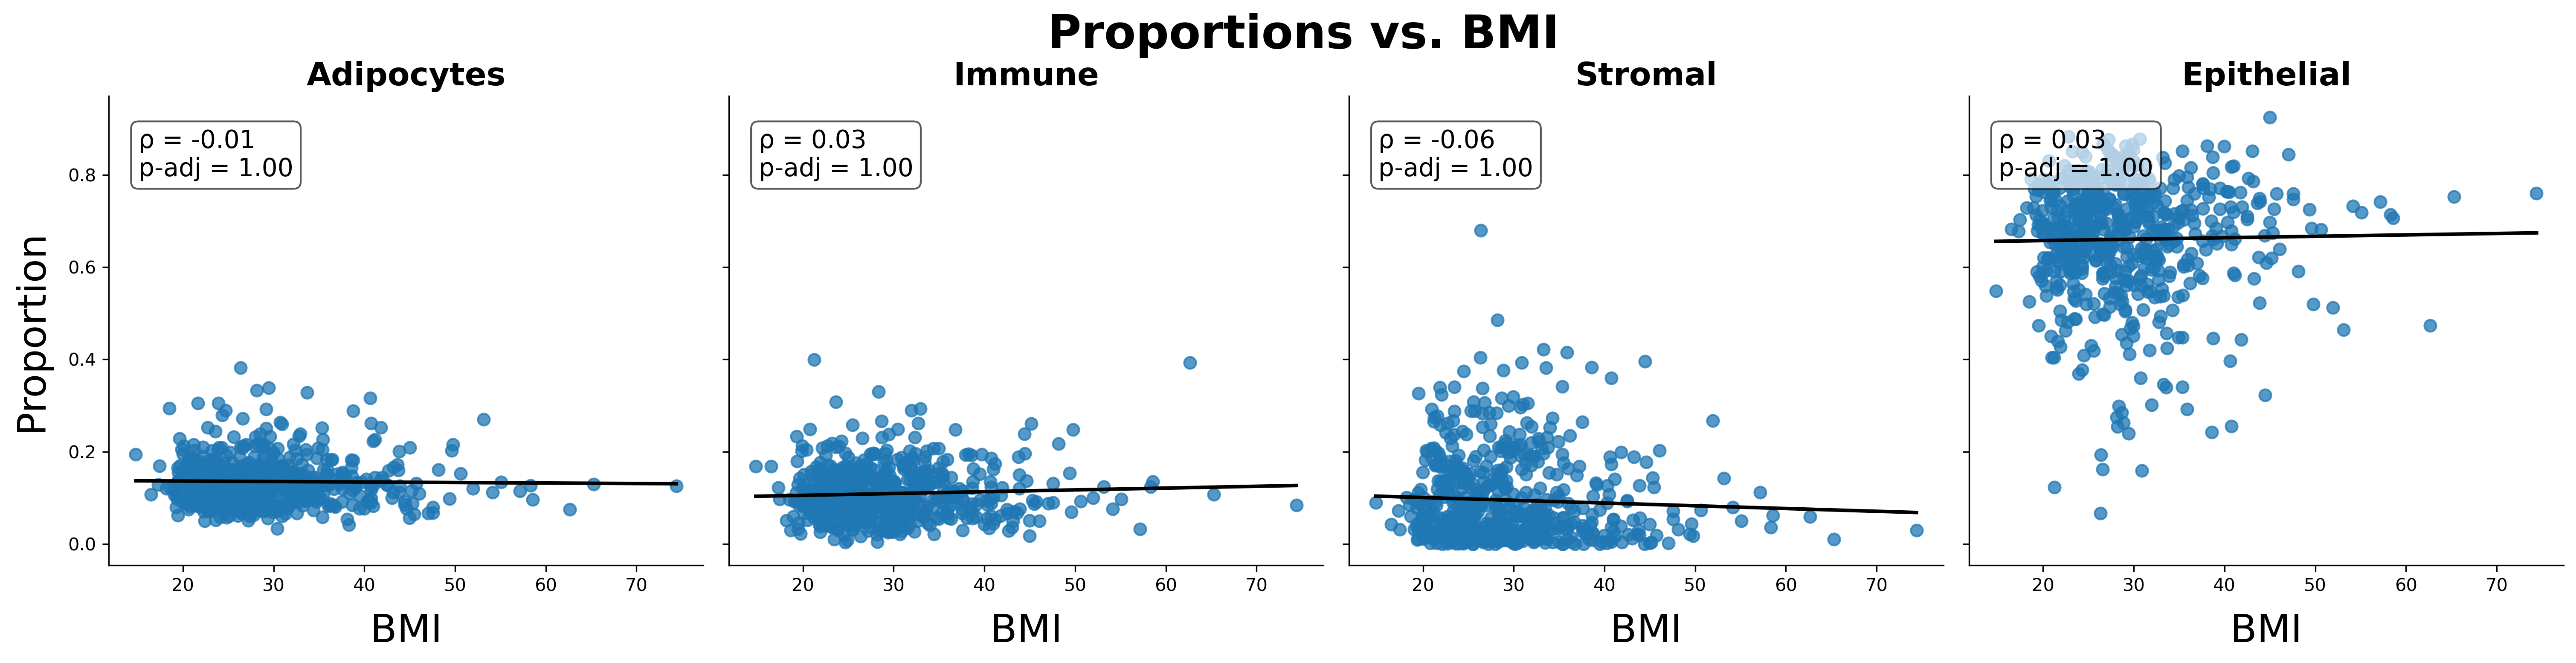

In [12]:
# ── 2.  Scatter/Trend plots ---------------------------------------------

for pred in predictors:  # “BMI”, then “Age”
    # ---- pre-compute Spearman correlations  ------------------------------
    rho_dict = {frac: spearmanr(macros[pred], macros[frac])[0] for frac in fractions}

    # ---- lmplot  ----------------------------------------------------------
    g = sns.lmplot(
        data=macros.melt(
            id_vars=predictors,
            value_vars=fractions,
            var_name="Fraction",
            value_name="Prop",
        ),
        x=pred,
        y="Prop",
        col="Fraction",
        ci=None,
        col_order=fractions,
        height=5.0,  # ↑ taller panels
        aspect=1.0,  # ↑ wider panels
        scatter_kws=dict(s=45, alpha=0.75),
        line_kws=dict(color="black", linewidth=2),
    )

    # ---- titles & labels  -------------------------------------------------
    g.set_titles(col_template="{col_name}", size=18, weight="bold")

    # Explicitly set x- and y-label font sizes
    g.set_xlabels(pred, fontsize=22, labelpad=10)
    g.set_ylabels("Proportion", fontsize=22, labelpad=10)

    g.fig.subplots_adjust(top=0.85)
    g.fig.suptitle(f"Proportions vs. {pred}", fontsize=26, weight="bold")

    # ---- annotate each facet with ρ and p  --------------------------------
    for ax, frac in zip(g.axes.flatten(), fractions):
        rho = rho_dict[frac]
        p_adj = out.loc[
            (out.Predictor == pred) & (out.Fraction == frac), "p_adj"
        ].values[0]
        ax.text(
            0.05,
            0.93,
            f"ρ = {rho:.2f}\n" f"p-adj = {p_adj:.2f}",
            transform=ax.transAxes,
            ha="left",
            va="top",
            fontsize=14,
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.65),
        )

    # ---- high-resolution display or save  --------------------------------
    g.fig.set_dpi(300)  # ↑ on-screen / inline resolution
    plt.show()

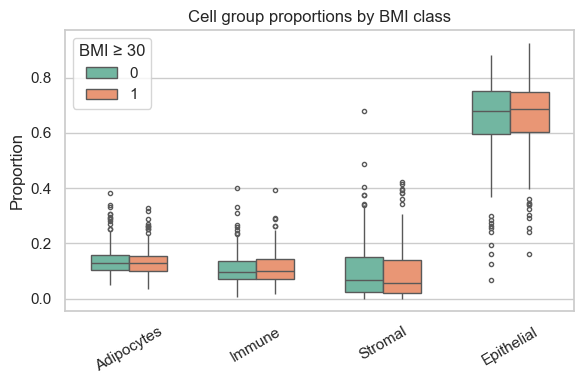

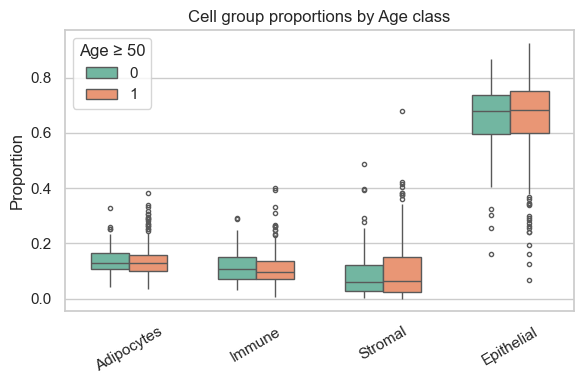

In [13]:
# Assuming df and `fractions` (your macro_cols list) already exist

# BMI version
long_bmi, ax_bmi = hp.boxplots_by_cutoff(
    df, feature="BMI", threshold=30, macro_cols=fractions
)

# Age version
long_age, ax_age = hp.boxplots_by_cutoff(
    df, feature="Age", threshold=50, macro_cols=fractions
)

Standardising (z-scores) lets us say “a 1-SD increase in BMI has < 1 % change in fraction” and makes the βs for BMI and Age directly comparable.

In [14]:
# ── standardise BMI & Age ───────────────────────────────────────────────
for c in ["BMI", "Age"]:
    df[c + "_z"] = (df[c] - df[c].mean()) / df[c].std(ddof=0)

# keep the original raw columns
predictors = ["BMI_z", "Age_z"]  # use the *z* columns from here on
df = df[fractions + predictors].copy()
df.head()

Adipocytes    Immune   Stromal  Epithelial     BMI_z     Age_z
ID                                                                   
40143    0.113422  0.218528  0.057419    0.610632 -0.794217  0.494063
41377    0.169611  0.096819  0.031381    0.702189 -1.539878 -0.449745
41387    0.064832  0.086715  0.122849    0.725604  2.071858 -0.344877
41391    0.119373  0.107769  0.111875    0.660983  0.251971  0.179460
41435    0.110333  0.087462  0.062252    0.739953 -0.703487  0.074593

/Users/ivicha/anaconda3/envs/env_hgsoc/lib/python3.10/site-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['Z']
  warnings.warn(msg, ValueWarning)


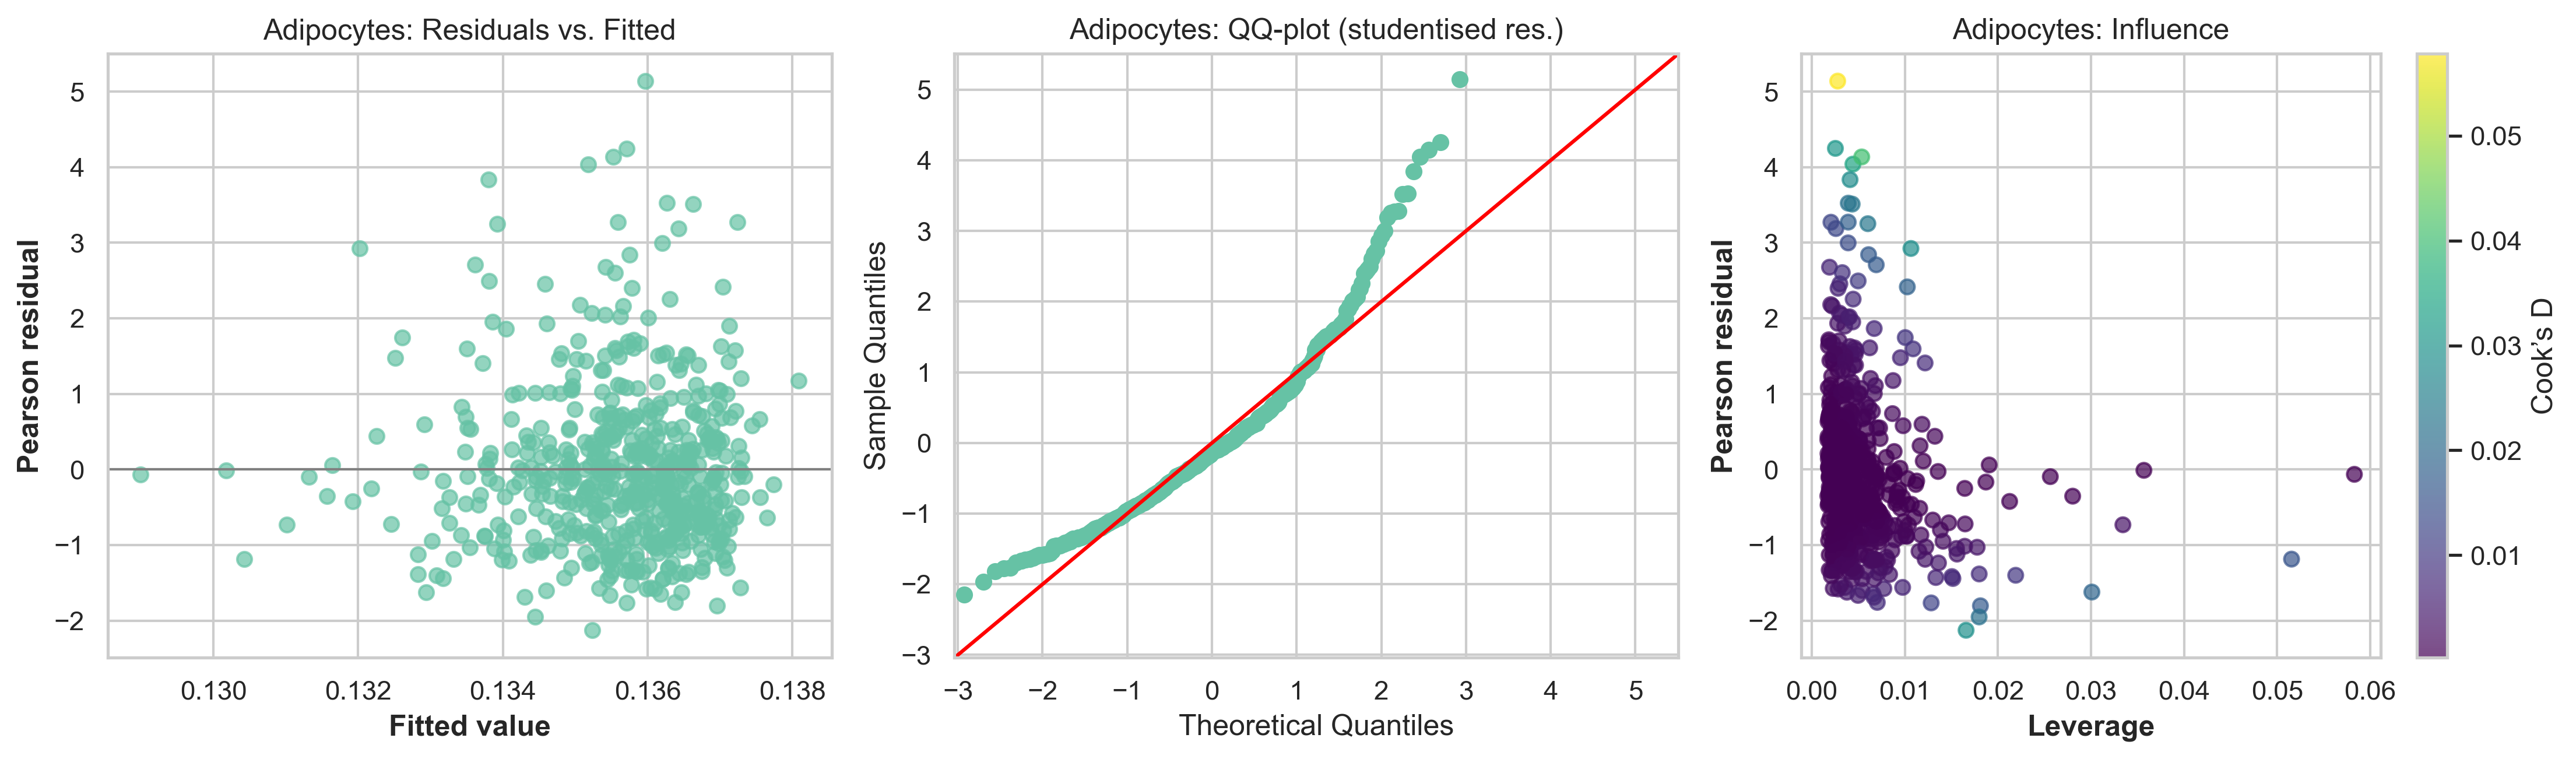

/Users/ivicha/anaconda3/envs/env_hgsoc/lib/python3.10/site-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['Z']
  warnings.warn(msg, ValueWarning)


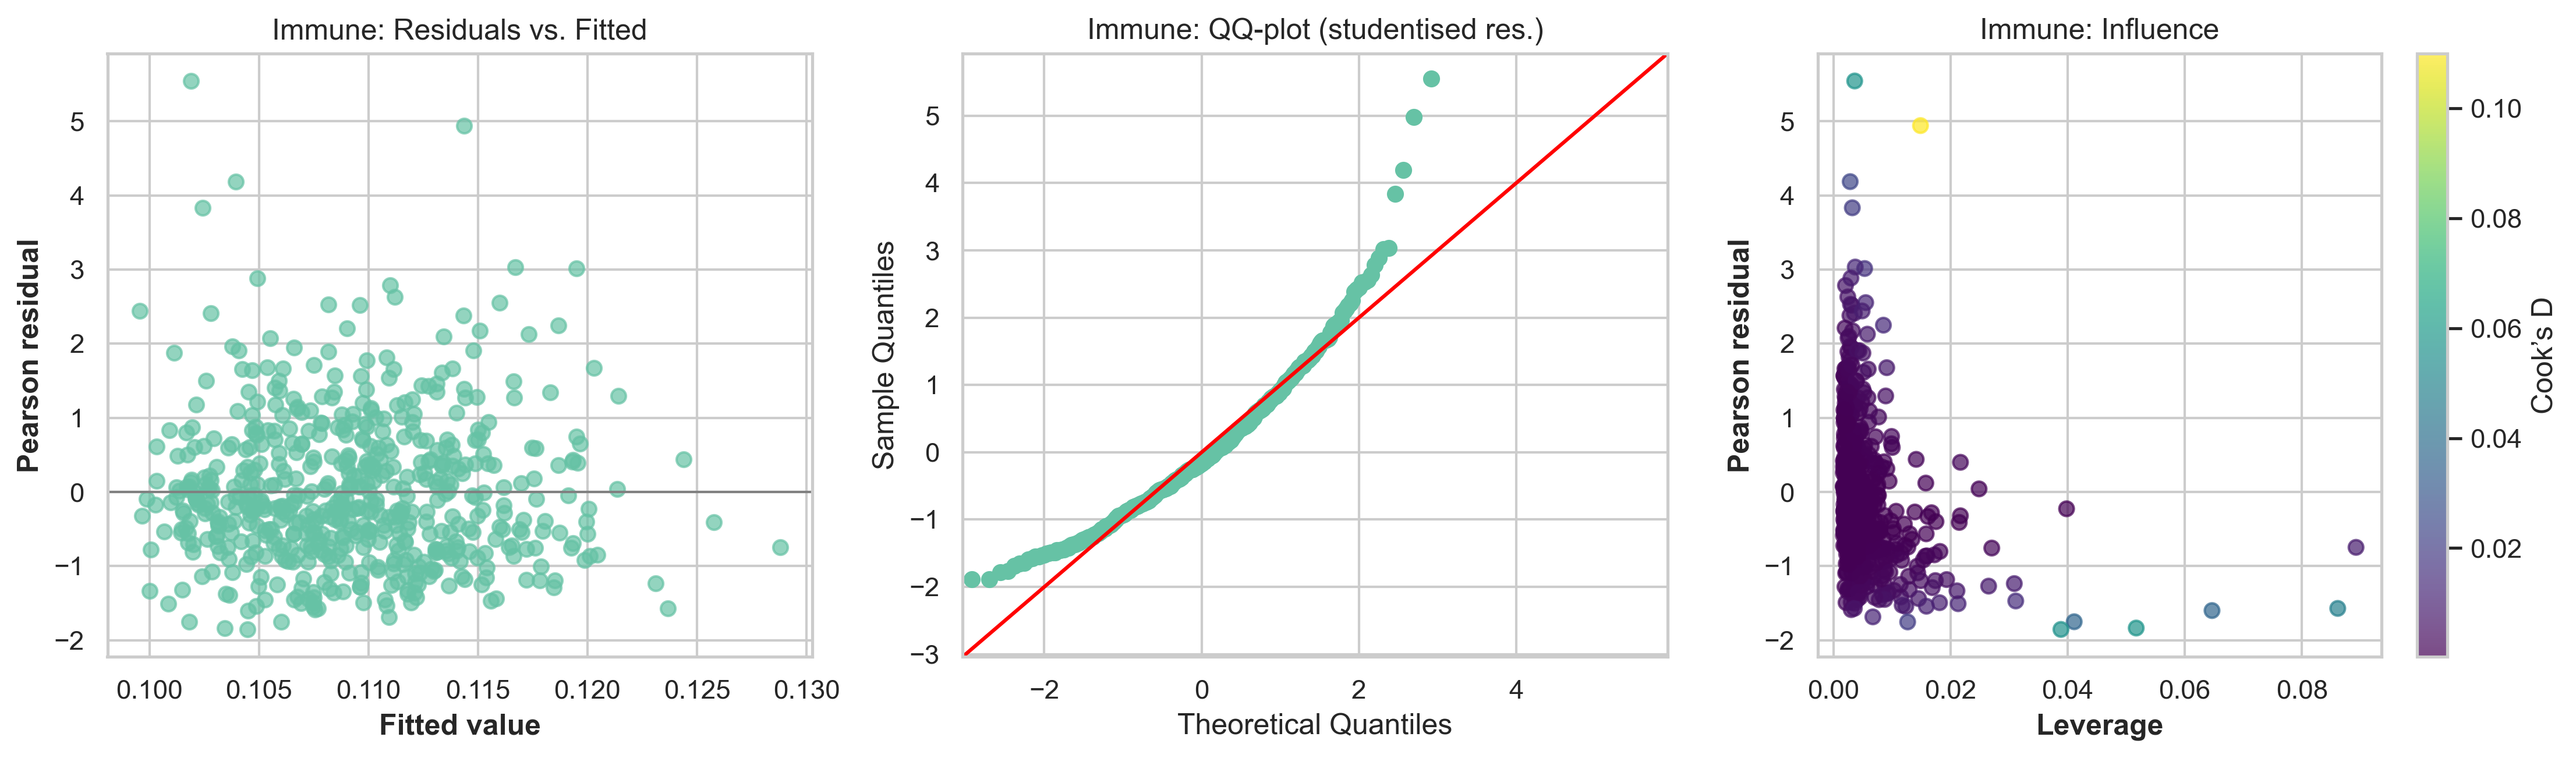

/Users/ivicha/anaconda3/envs/env_hgsoc/lib/python3.10/site-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['Z']
  warnings.warn(msg, ValueWarning)


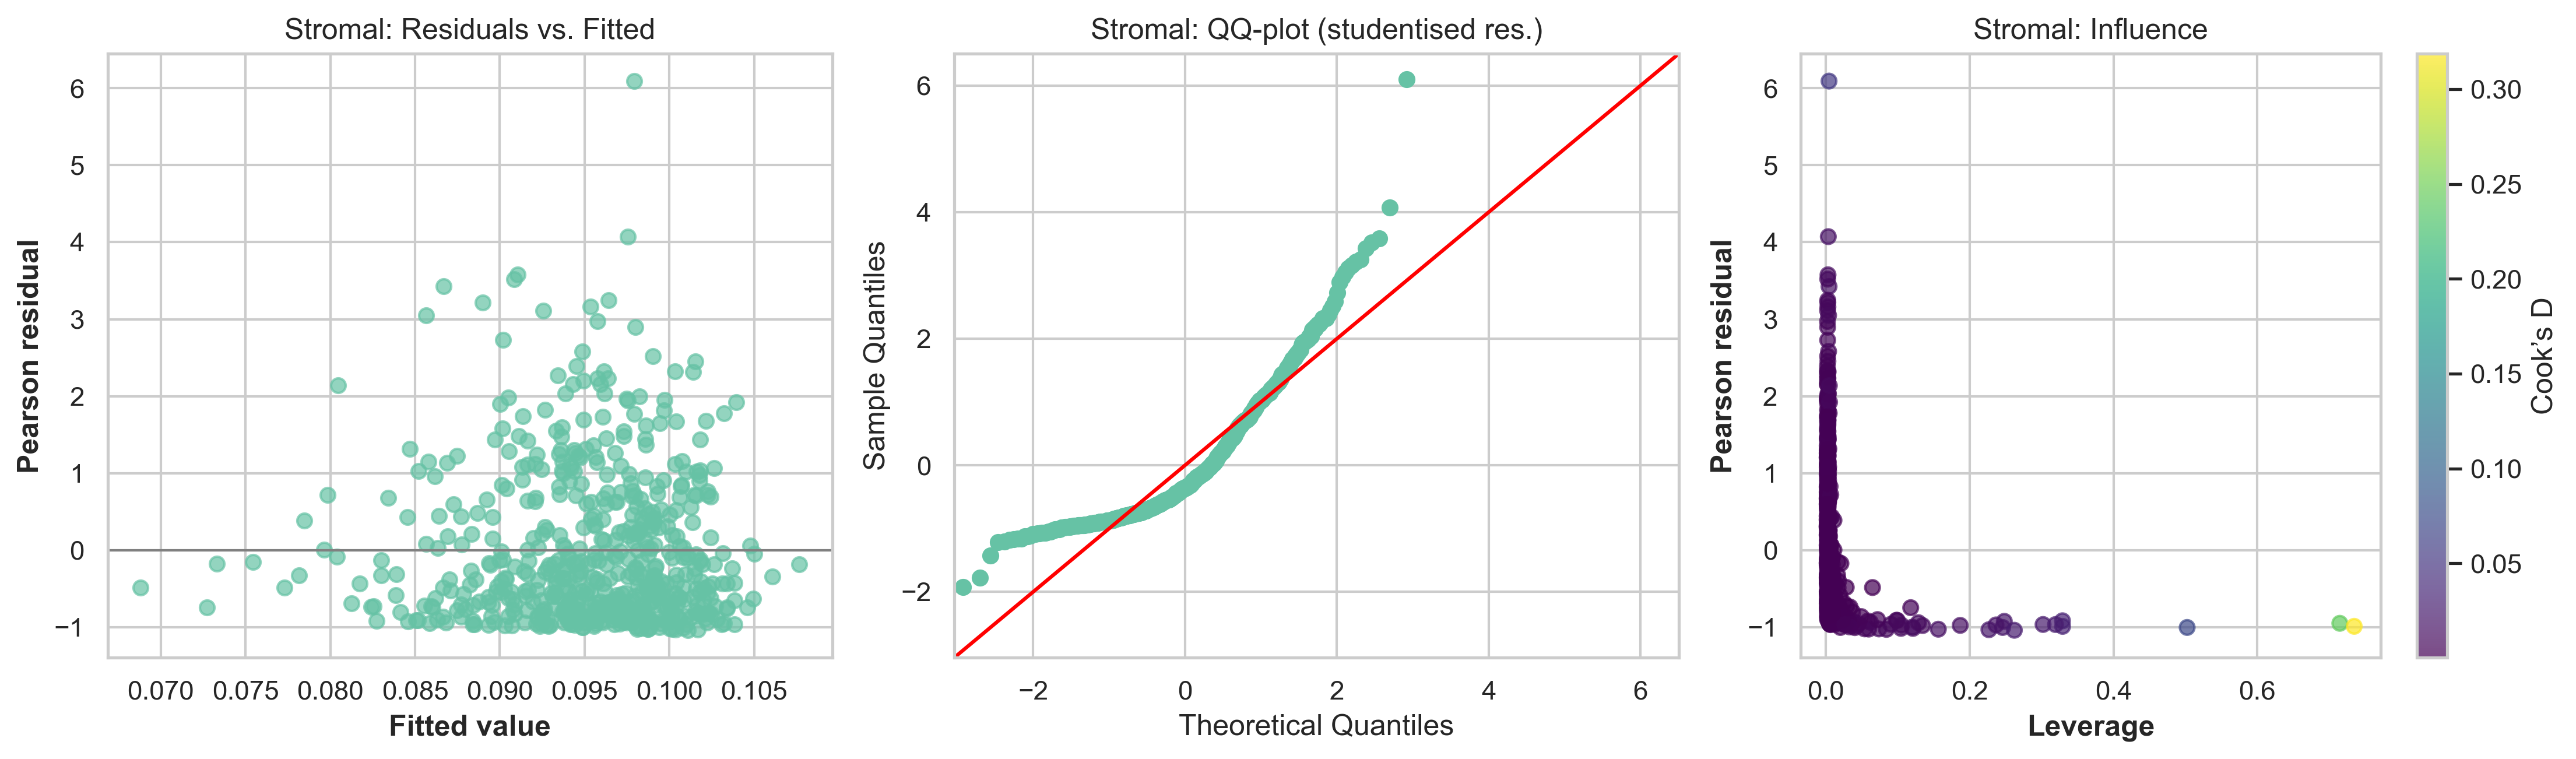

/Users/ivicha/anaconda3/envs/env_hgsoc/lib/python3.10/site-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['Z']
  warnings.warn(msg, ValueWarning)


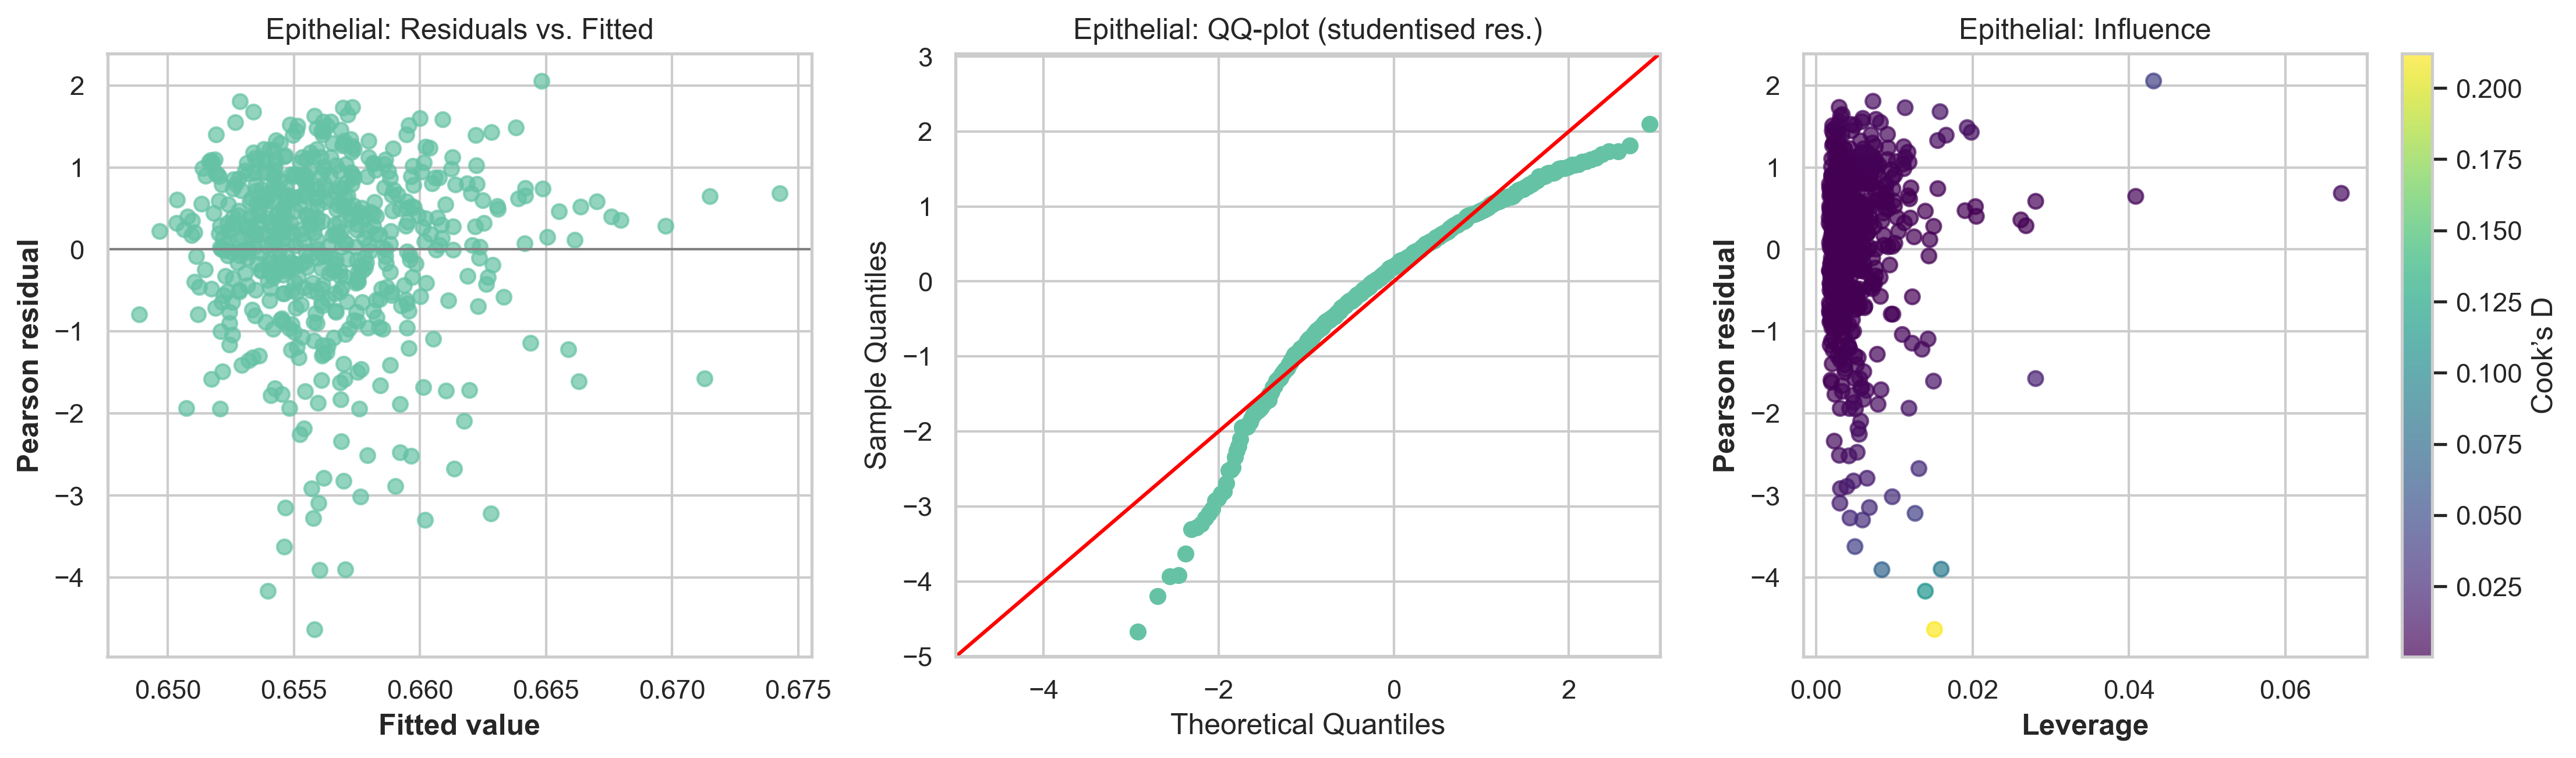

Fraction Predictor      Beta    CI_low   CI_high     p_raw     p_adj
0  Adipocytes       BMI -0.010313 -0.042981  0.022355  0.536082  1.000000
1  Adipocytes       Age -0.001242 -0.034054  0.031570  0.940850  1.000000
2      Immune       BMI  0.018790 -0.024997  0.062577  0.400308  1.000000
3      Immune       Age -0.046342 -0.090269 -0.002414  0.038672  0.309374
4     Stromal       BMI -0.064603 -0.138149  0.008943  0.085137  0.681097
5     Stromal       Age -0.012797 -0.084791  0.059198  0.727561  1.000000
6  Epithelial       BMI  0.014998 -0.030641  0.060638  0.519510  1.000000
7  Epithelial       Age  0.003974 -0.041856  0.049803  0.865059  1.000000

In [15]:
# %% --- Beta-regression: BMI & Age vs each macro fraction --------------
results = []

for frac in fractions:  # e.g. ['Adipocytes', 'Immune', …]
    eps = 5e-4  # or tighter for fractions never near 0/1
    y = (
        df[frac].clip(eps, 1 - eps).values
    )  # mean sub-model (μ) and precision sub-model (φ) use the same covariates
    X_mean = sm.add_constant(df[["BMI_z", "Age_z"]]).rename(
        columns={"BMI_z": "BMI", "Age_z": "Age"}
    )
    X_prec = X_mean.copy()  # precision design matrix

    model = BetaModel(y, X_mean, Z=X_prec).fit()  # <— precision sub-model!
    # collect coefficients, CIs, p-values
    for pred in ["BMI", "Age"]:
        results.append(
            {
                "Fraction": frac,
                "Predictor": pred,
                "Beta": model.params[pred],
                "CI_low": model.conf_int().loc[pred, 0],
                "CI_high": model.conf_int().loc[pred, 1],
                "p_raw": model.pvalues[pred],
            }
        )

    hp.beta_diagnostics(model, frac)  # ← call the helper

# organise results
coef_df = pd.DataFrame(results)

# ── Benjamini–Hochberg (8 tests) ----------------------------------------
coef_df["p_adj"] = multipletests(coef_df["p_raw"], method="bonferroni")[1]
coef_df

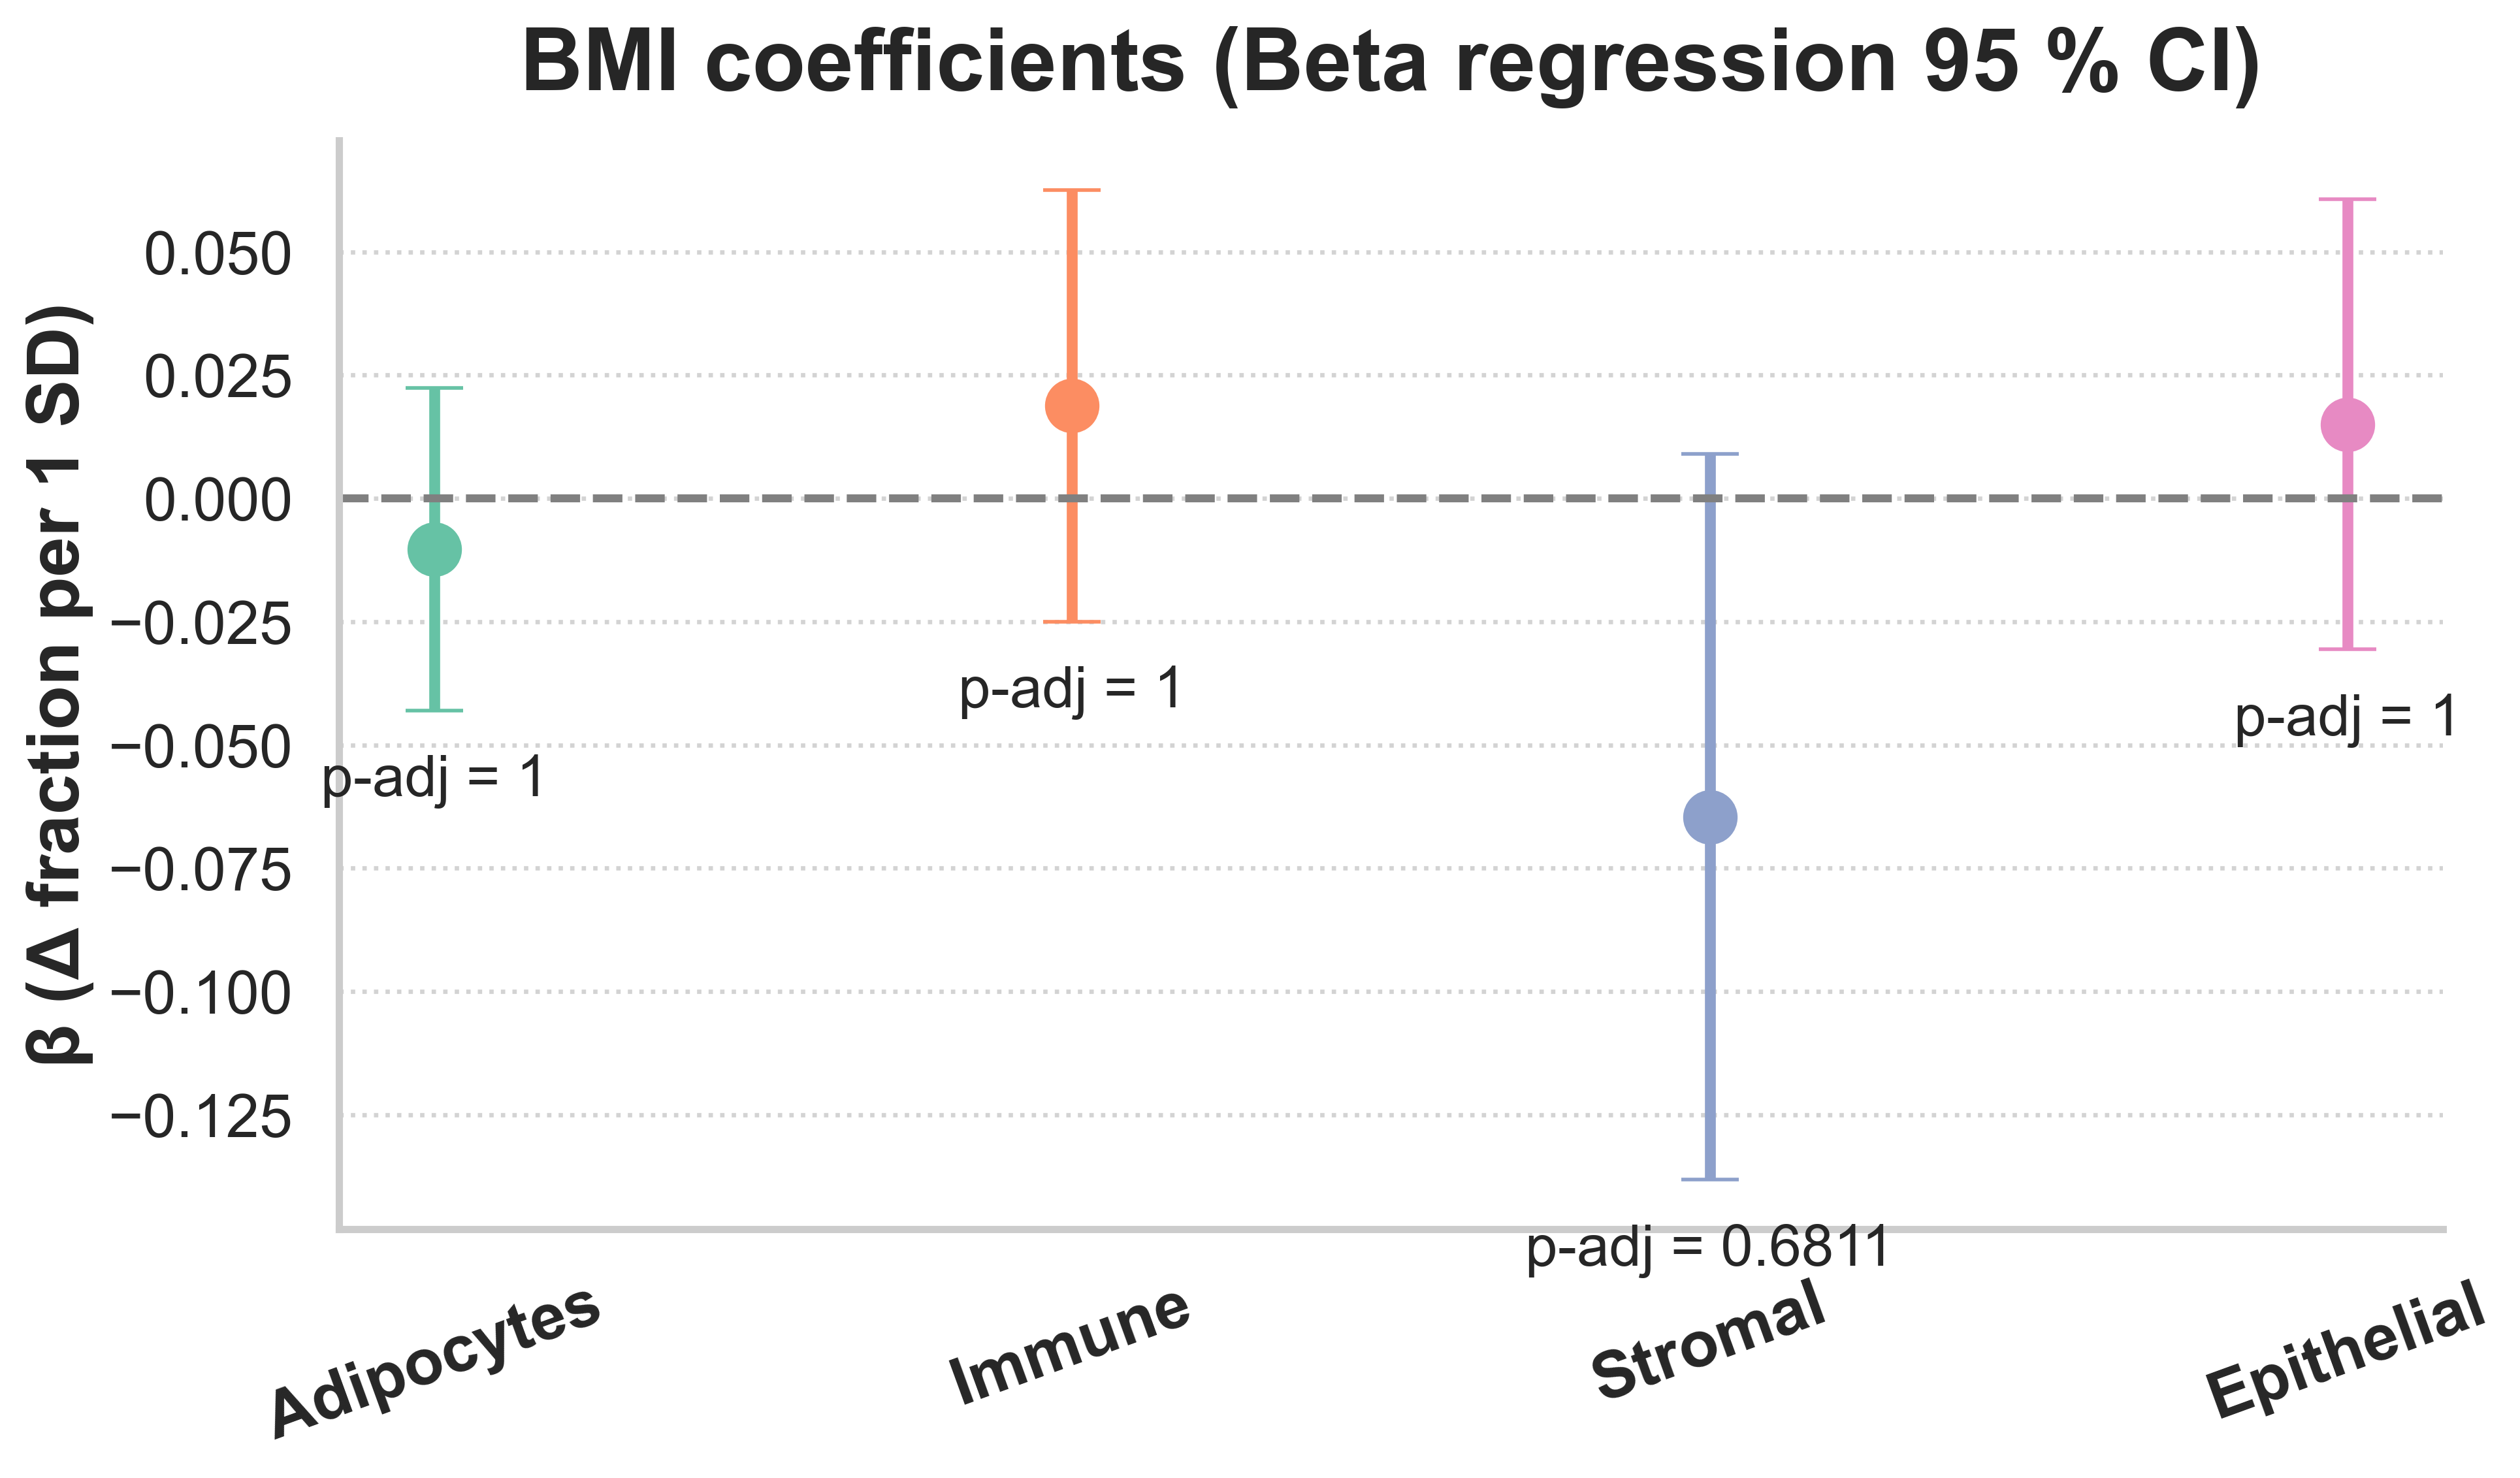

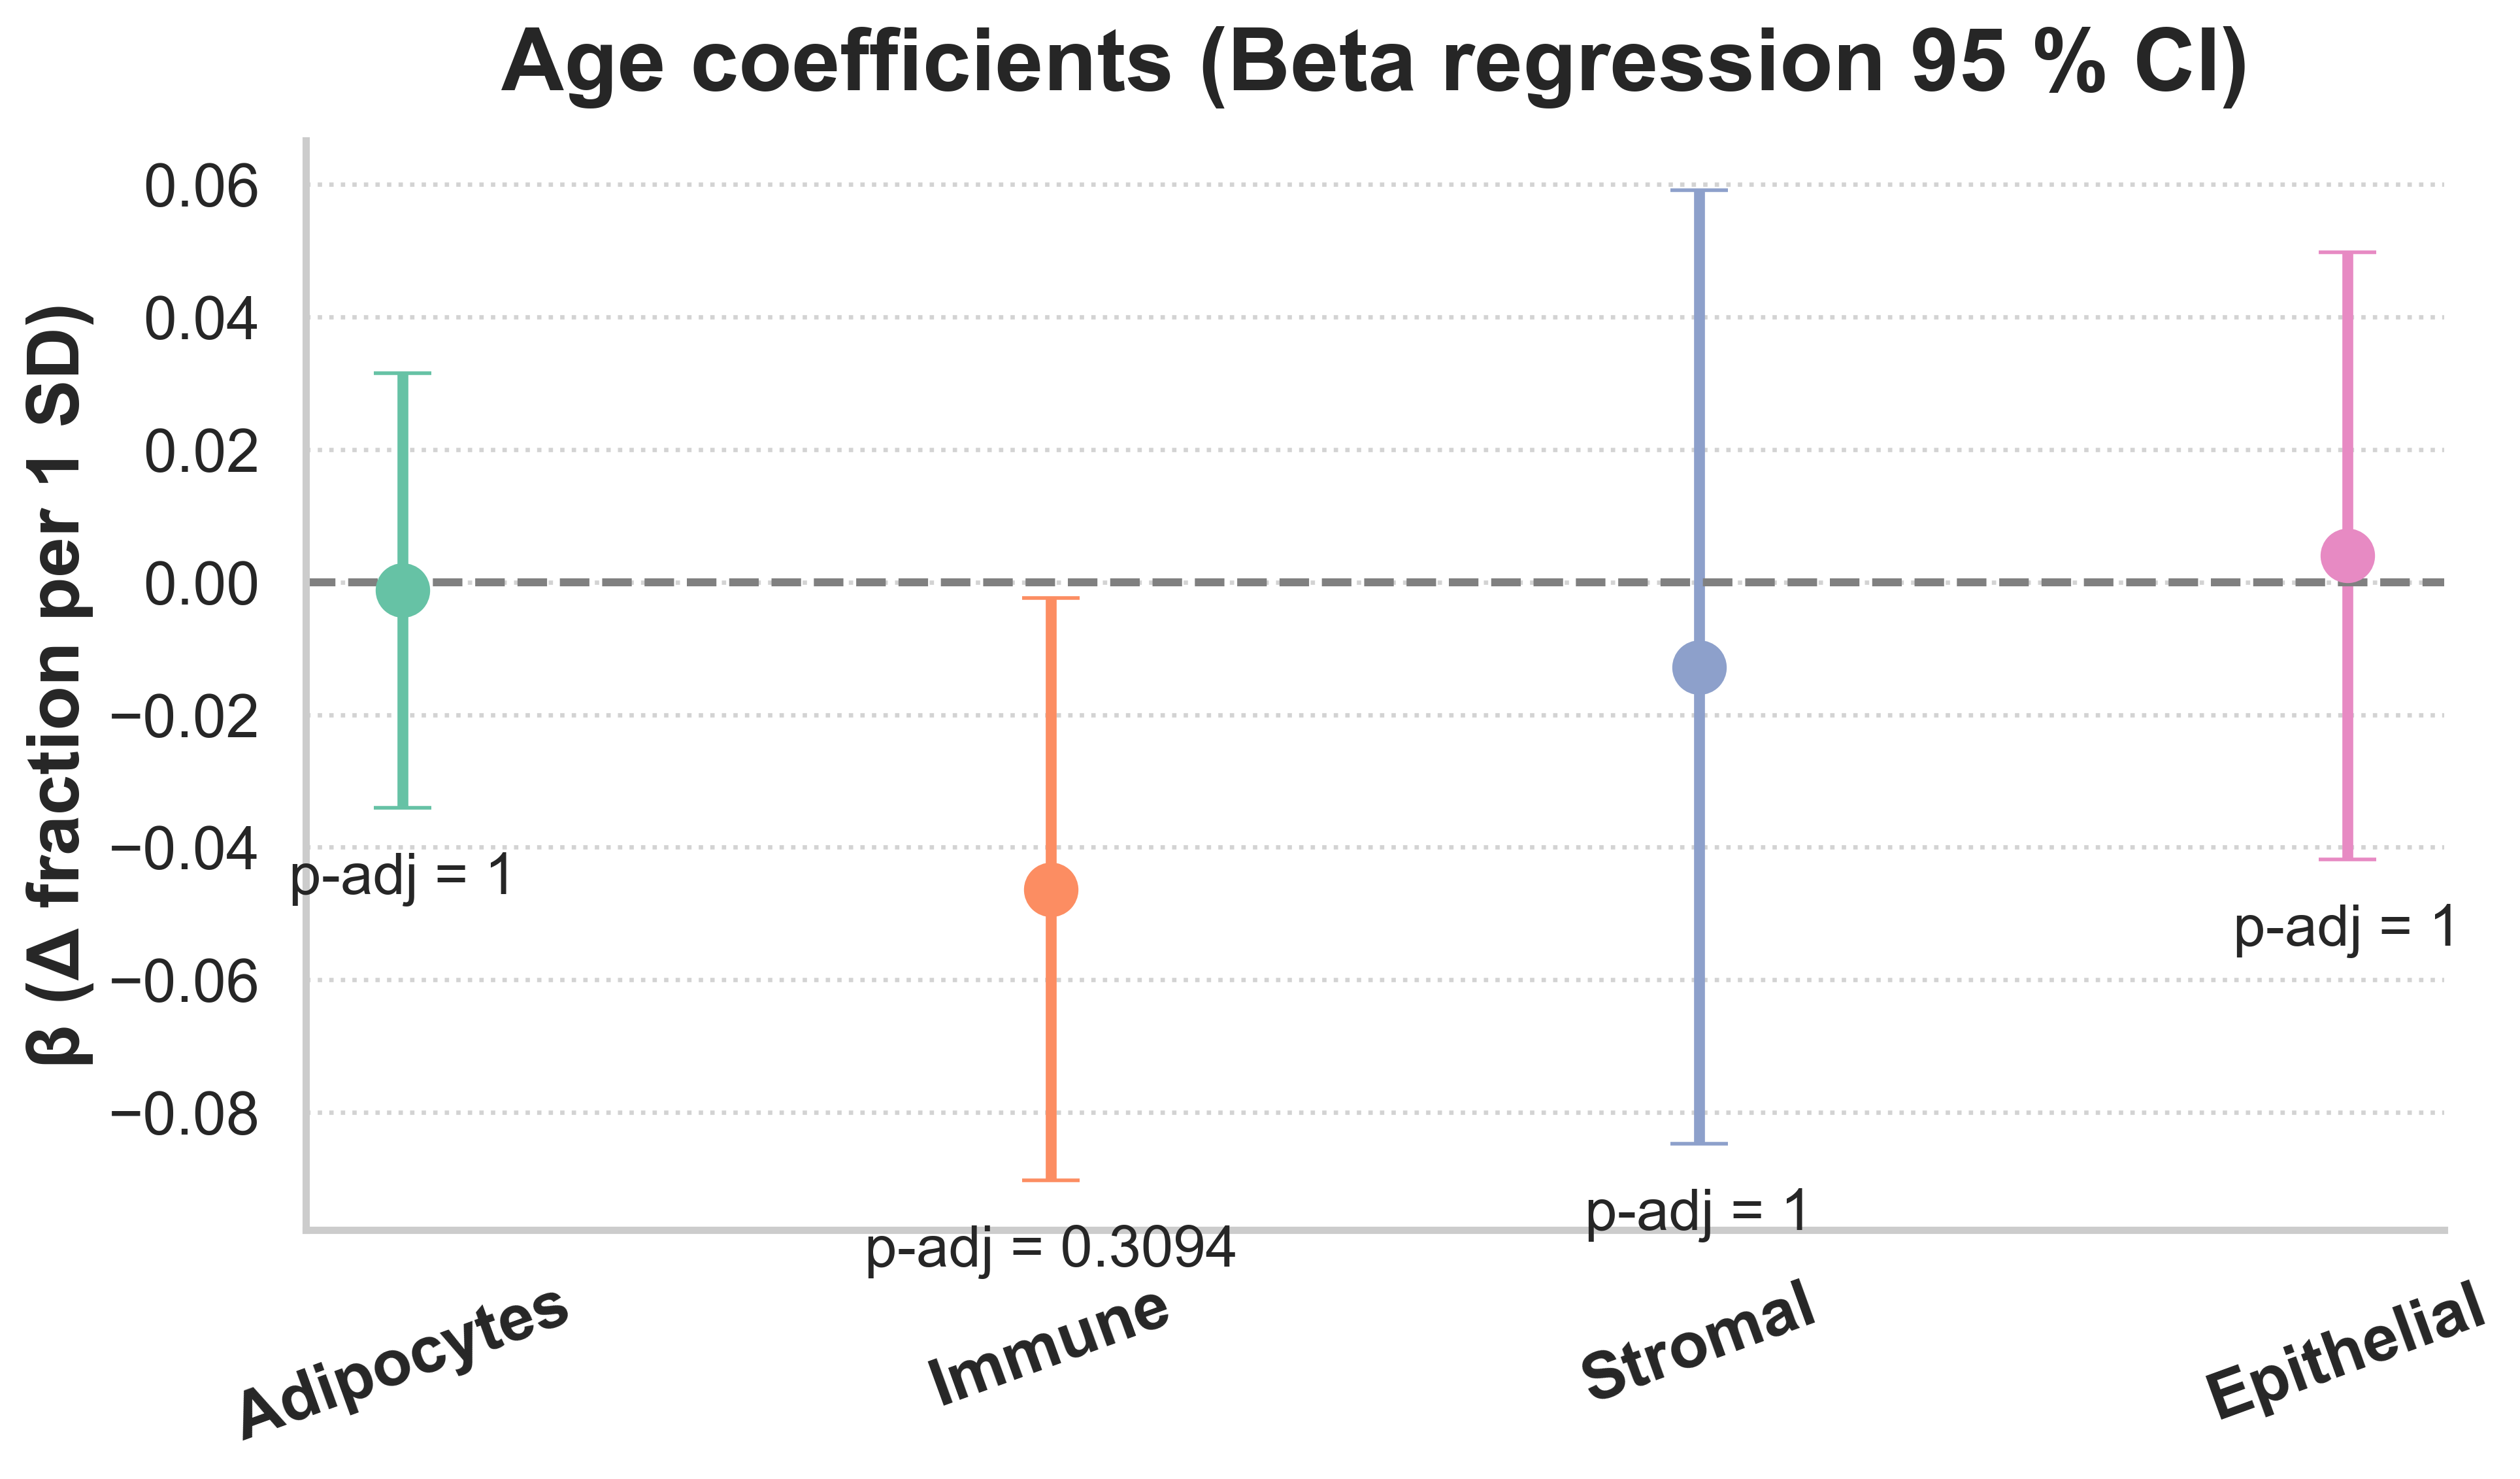

In [16]:
# %% --- Coefficient plots (large & clean) --------------------------------
sns.set_theme(style="whitegrid", context="talk")

plt.rcParams.update(
    {
        "font.size": 18,
        "axes.labelweight": "bold",
        "axes.titlesize": 24,
        "axes.titleweight": "bold",
        "axes.linewidth": 2.0,
        "xtick.major.width": 1.8,
        "ytick.major.width": 1.8,
    }
)

for pred in ["BMI", "Age"]:
    fig, ax = plt.subplots(figsize=(10, 6), dpi=400)

    subset = coef_df[coef_df.Predictor == pred]
    colours = sns.color_palette("Set2", len(fractions))

    for i, (_, row) in enumerate(subset.iterrows()):
        ax.errorbar(
            i,
            row["Beta"],
            yerr=[[row["Beta"] - row["CI_low"]], [row["CI_high"] - row["Beta"]]],
            fmt="o",
            markersize=14,
            capsize=8,
            linewidth=3,
            color=colours[i],
            ecolor=colours[i],
            elinewidth=3,
        )
        p_txt = "p-adj = 1" if row["p_adj"] == 1 else f"p-adj = {row['p_adj']:.4f}"
        ax.annotate(
            p_txt,
            xy=(i, row["CI_low"]),
            xytext=(0, -12),
            textcoords="offset points",
            ha="center",
            va="top",
            fontsize=16,
        )

    ax.axhline(0, ls="--", color="gray", lw=2.2)

    ax.set_xticks(range(len(fractions)))
    ax.set_xticklabels(fractions, rotation=20, weight="bold", fontsize=18)
    ax.set_ylabel("β (Δ fraction per 1 SD)", weight="bold", fontsize=20)
    ax.set_title(f"{pred} coefficients (Beta regression 95 % CI)", pad=14)

    ax.set_facecolor("white")  # wipe background stripes
    ax.grid(False)
    ax.grid(
        axis="y",
        which="major",
        linestyle=":",
        linewidth=1.2,
        color="lightgray",
        zorder=0,
    )

    sns.despine(ax=ax, trim=False)
    fig.tight_layout()
    plt.show()